With quantile transformer

In [2]:
!pip install keras_tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import keras_tuner as kt

# ------------------ 读取与预处理数据 ------------------ #
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
target_col = "Drought_Index"
exclude_cols = ['Province', 'Season','Yield', target_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
y = df[target_col].values

# 训练 / 验证 / 测试
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# QuantileTransformer y
y_transformer = QuantileTransformer(output_distribution='normal')
y_train_trans = y_transformer.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_trans = y_transformer.transform(y_val.reshape(-1, 1)).flatten()
y_test_trans = y_transformer.transform(y_test.reshape(-1, 1)).flatten()

# hyperparameters tuning
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int("num_layers", 1, 3)):
        units = hp.Int(f"units_{i}", 32, 256, step=32)
        model.add(keras.layers.Dense(units, activation='relu'))
        dropout = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(1))  # output layer
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="ann_tuner",
    project_name="yield_prediction_quantile"
)

tuner.search(X_train, y_train_trans, validation_data=(X_val, y_val_trans),
             epochs=100, batch_size=32,
             callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
             verbose=1)

# get best model
best_model = tuner.get_best_models(num_models=1)[0]

# ------------------ 模型评估函数 ------------------ #
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

def evaluate(model, X, y_true_trans, y_true_original, name):
    y_pred_trans = model.predict(X).flatten()
    y_pred = y_transformer.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
    r2 = r2_score(y_true_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred))
    smape_val = smape(y_true_original, y_pred)
    print(f"{name} R²: {r2:.3f}, RMSE: {rmse:.3f}, SMAPE: {smape_val:.2f}%")
    return r2, rmse, smape_val

evaluate(best_model, X_train, y_train_trans, y_train, "train")
evaluate(best_model, X_val, y_val_trans, y_val, "val")
evaluate(best_model, X_test, y_test_trans, y_test, "test")
best_model.summary()

Trial 10 Complete [00h 00m 14s]
val_loss: 0.39475980401039124

Best val_loss So Far: 0.39475980401039124
Total elapsed time: 00h 01m 58s
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


train R²: 0.616, RMSE: 0.511, SMAPE: 32.40%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
val R²: 0.608, RMSE: 0.481, SMAPE: 30.40%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
test R²: 0.538, RMSE: 0.513, SMAPE: 35.88%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 224)            │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,841 (343.13 KB)

 Trainable params: 87,841 (343.13 KB)

 Non-trainable params: 0 (0.00 B)

   num_layers  units_0  dropout_0  units_1  dropout_1  units_2  dropout_2  \
0           3       32        0.0       32        0.0       32        0.0   
1           1      160        0.4       32        0.4       64        0.4   
2           2       96        0.3      224        0.2      160        0.3   
3           1       32        0.3      128        0.1      256        0.0   
4           2       32        0.1       96        0.2       32        0.2   
5           3      160        0.0      256        0.0      224        0.3   
6           1      160        0.0      160        0.0       64        0.0   
7           1      160        0.4       32        0.0       32        0.2   
8           1       64        0.1      192        0.4       32        0.1   
9           3      224        0.3      192        0.2      192        0.3   

   val_loss  
0  0.470558  
1  0.469645  
2  0.442707  
3  0.499185  
4  0.470710  
5  0.427954  
6  0.421648  
7  0.455947  
8  0.462220  
9  0.394760 

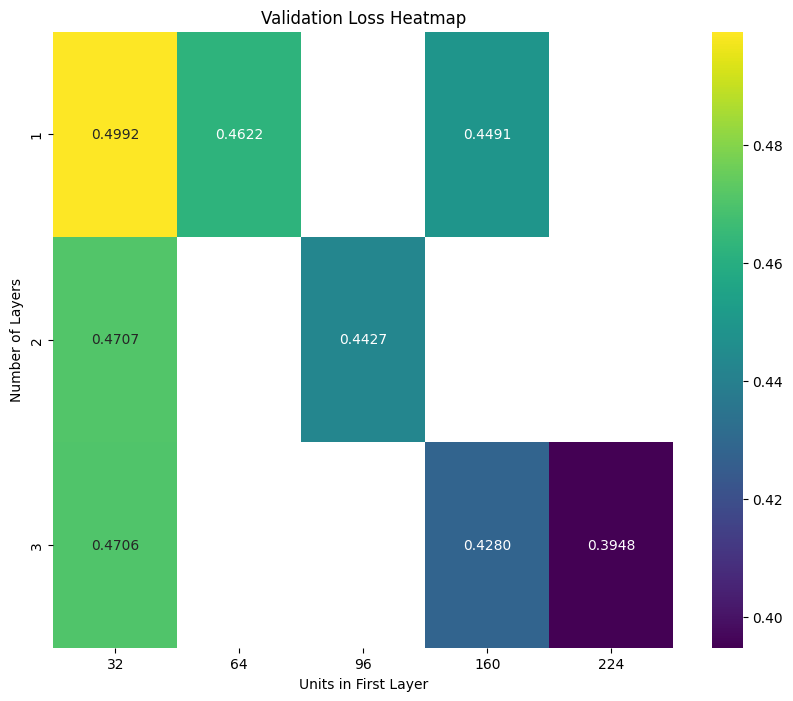

In [4]:
import seaborn as sns

trials = tuner.oracle.trials.values()


# 2. 整理成DataFrame
records = []
for trial in trials:
    hp = trial.hyperparameters.values
    val_loss = trial.score
    record = {**hp, 'val_loss': val_loss}
    records.append(record)

df_trials = pd.DataFrame(records)

print(df_trials)

# 3. 举个例子：画 "num_layers" 和 "units_0" 对 "val_loss" 的热力图
if 'units_0' in df_trials.columns:
    pivot_table = df_trials.pivot_table(index='num_layers', columns='units_0', values='val_loss')

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
    plt.title('Validation Loss Heatmap')
    plt.ylabel('Number of Layers')
    plt.xlabel('Units in First Layer')
    plt.show()


Without quantile transformer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

# ------------------ 读取与预处理数据 ------------------ #
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
target_col = "Drought_Index"
exclude_cols = ['Province', 'Season','Yield', target_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
y = df[target_col].values

# 训练 / 验证 / 测试拆分
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# ------------------ 模型构建函数 (用于调优) ------------------ #
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int("num_layers", 1, 3)):
        units = hp.Int(f"units_{i}", 32, 256, step=32)
        model.add(keras.layers.Dense(units, activation='relu'))
        dropout = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(1))  # 输出层
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------ 超参数搜索 ------------------ #
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="ann_tuner",
    project_name="yield_prediction_no_quantile"
)

tuner.search(X_train, y_train, validation_data=(X_val, y_val),
             epochs=100, batch_size=32,
             callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
             verbose=1)

# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

# ------------------ 模型评估函数 ------------------ #
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

def evaluate(model, X, y_true, name):
    y_pred = model.predict(X).flatten()
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape_val = smape(y_true, y_pred)
    print(f"{name}R²: {r2:.3f}, RMSE: {rmse:.3f}, SMAPE: {smape_val:.2f}%")
    return r2, rmse, smape_val

# ------------------ 模型评估 ------------------ #
evaluate(best_model, X_train, y_train, "train ")
evaluate(best_model, X_val, y_val, "val   ")
evaluate(best_model, X_test, y_test, "test  ")
best_model.summary()

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import random
import os

# === 固定种子 ===
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

# === 加载数据 ===
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
df = df.dropna()

months = ['11', '12', '1', '2', '3', '4', '5', '6']
variables = ['GPP', 'SMCI', 'TCI_mean', 'VCI_mean']
features_all = [f"{var}_{month}" for month in months for var in variables]

X = df[features_all].values.reshape(-1, len(months), len(variables))  # (样本数, 8, 4)
y = df['Yield'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === SMAPE 评估函数 ===
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

# === Optuna 目标函数 ===
def objective(trial):
    tf.keras.backend.clear_session()
    set_seed(42)

    # 超参数搜索空间
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 96, 128])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # 构建模型
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(8, 4), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # 训练模型
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=100,
              batch_size=16,
              callbacks=[early_stopping],
              verbose=0)

    # 验证预测与评估
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred)
    smape_val = smape(y_val, y_pred)

    trial.set_user_attr("r2", r2)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("smape", smape_val)

    return rmse
# === 启动搜索 ===
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# === 打印结果 ===
best_trial = study.best_trial
print("\n🌟 最佳参数组合:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

print(f"\n最佳模型性能:")
print(f"R²: {best_trial.user_attrs['r2']:.4f}")
print(f"RMSE: {best_trial.user_attrs['rmse']:.4f}")
print(f"SMAPE: {best_trial.user_attrs['smape']:.2f}%")


[I 2025-04-16 16:31:27,719] A new study created in memory with name: no-name-a68c798b-e673-4604-a637-dc4cd27a3dc6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-04-16 16:32:03,567] Trial 0 finished with value: 0.3426831510082384 and parameters: {'lstm_units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.009043269399303392}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-04-16 16:32:40,699] Trial 1 finished with value: 0.35011206214811197 and parameters: {'lstm_units': 64, 'dropout': 0.5, 'learning_rate': 0.005793008184537307}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-04-16 16:33:18,978] Trial 2 finished with value: 0.5410769343392129 and parameters: {'lstm_units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.0001965568127282912}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-04-16 16:33:55,367] Trial 3 finished with value: 0.5231231002799792 and parameters: {'lstm_units': 96, 'dropout': 0.4, 'learning_rate': 0.00035109408918086423}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-04-16 16:34:48,147] Trial 4 finished with value: 0.43978000227324077 and parameters: {'lstm_units': 128, 'dropout': 0.2, 'learning_rate': 0.0008308793357846818}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:35:41,214] Trial 5 finished with value: 0.5364712126015678 and parameters: {'lstm_units': 128, 'dropout': 0.4, 'learning_rate': 0.00011783120975270126}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:36:16,308] Trial 6 finished with value: 0.5180750814929705 and parameters: {'lstm_units': 32, 'dropout': 0.2, 'learning_rate': 0.0006662870197782245}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:37:08,193] Trial 7 finished with value: 0.4768470605591741 and parameters: {'lstm_units': 128, 'dropout': 0.4, 'learning_rate': 0.000774706888031526}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-04-16 16:38:00,203] Trial 8 finished with value: 0.5258273628967132 and parameters: {'lstm_units': 128, 'dropout': 0.2, 'learning_rate': 0.0003331921337014265}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:38:34,450] Trial 9 finished with value: 0.5320441963936055 and parameters: {'lstm_units': 64, 'dropout': 0.2, 'learning_rate': 0.00021668255117139842}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-04-16 16:39:10,956] Trial 10 finished with value: 0.35201398339459017 and parameters: {'lstm_units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.009615482397466922}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-04-16 16:39:45,024] Trial 11 finished with value: 0.35490671386033057 and parameters: {'lstm_units': 64, 'dropout': 0.5, 'learning_rate': 0.00812812400209397}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:40:20,561] Trial 12 finished with value: 0.4167768571584664 and parameters: {'lstm_units': 64, 'dropout': 0.5, 'learning_rate': 0.003453910307462399}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:40:55,451] Trial 13 finished with value: 0.394993035127288 and parameters: {'lstm_units': 32, 'dropout': 0.30000000000000004, 'learning_rate': 0.003646187645563585}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-04-16 16:41:24,743] Trial 14 finished with value: 0.44123006353749095 and parameters: {'lstm_units': 64, 'dropout': 0.5, 'learning_rate': 0.0028247468812308274}. Best is trial 0 with value: 0.3426831510082384.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-04-16 16:42:02,696] Trial 15 finished with value: 0.3418227866325214 and parameters: {'lstm_units': 96, 'dropout': 0.4, 'learning_rate': 0.005214034303487014}. Best is trial 15 with value: 0.3418227866325214.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-04-16 16:42:42,034] Trial 16 finished with value: 0.41822327299567463 and parameters: {'lstm_units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.0017165158816358564}. Best is trial 15 with value: 0.3418227866325214.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-04-16 16:43:18,859] Trial 17 finished with value: 0.43796723363010076 and parameters: {'lstm_units': 96, 'dropout': 0.4, 'learning_rate': 0.0016609910589882664}. Best is trial 15 with value: 0.3418227866325214.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-04-16 16:43:54,564] Trial 18 finished with value: 0.31466926720337585 and parameters: {'lstm_units': 96, 'dropout': 0.4, 'learning_rate': 0.005331917665104846}. Best is trial 18 with value: 0.31466926720337585.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-04-16 16:44:30,501] Trial 19 finished with value: 0.3259873198511788 and parameters: {'lstm_units': 96, 'dropout': 0.4, 'learning_rate': 0.005273290034898793}. Best is trial 18 with value: 0.31466926720337585.



🌟 最佳参数组合:
lstm_units: 96
dropout: 0.4
learning_rate: 0.005331917665104846

最佳模型性能:
R²: 0.6573
RMSE: 0.3147
SMAPE: 92.32%


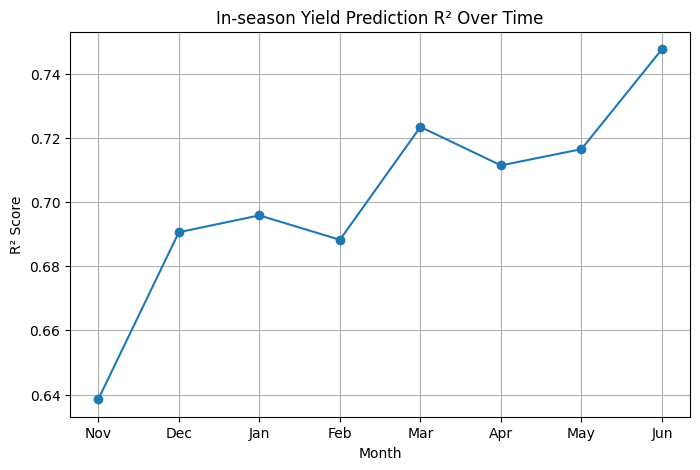

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")

# 月份顺序列表（11月到次年6月）
month_order = [11, 12, 1, 2, 3, 4, 5, 6]

# 保存每个月的R方结果
r2_results = []

# 基础特征（比如Drought_Index, Province等，如果想加的话）
base_features = ['Drought_Index']  # 注意：Province如果是文字的话要编码成数值才能用，或者先不加

for end_month in month_order:
    # 确定当前需要用到哪些特征
    selected_features = []
    for m in month_order:
        if (end_month >= 11 and (m >= 11 and m <= end_month)) or (end_month < 11 and (m >= 11 or m <= end_month)):
            selected_features.extend([
                f'GPP_{m}',
                f'SMCI_{m}',
                f'TCI_mean_{m}',
                f'VCI_mean_{m}'
            ])

    # 最终的特征列表
    features = base_features + selected_features

    # 取出对应特征和目标
    X = df[features]
    y = df['Yield']

    # 划分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 训练模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)

    # 计算R2
    r2 = r2_score(y_test, y_pred)
    r2_results.append((end_month, r2))

# 画图
months_label = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
r2_values = [r[1] for r in r2_results]

plt.figure(figsize=(8,5))
plt.plot(months_label, r2_values, marker='o')
plt.xlabel("Month")
plt.ylabel("R² Score")
plt.title("In-season Yield Prediction R² Over Time")
plt.grid(True)
plt.show()


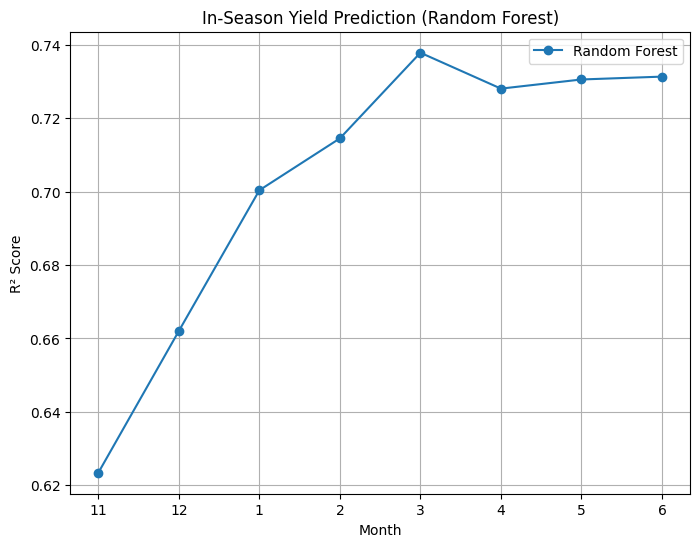

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")

# 特征和标签
feature_cols = [
    'GPP_11','GPP_12','GPP_1','GPP_2','GPP_3','GPP_4','GPP_5','GPP_6',
    'SMCI_11','SMCI_12','SMCI_1','SMCI_2','SMCI_3','SMCI_4','SMCI_5','SMCI_6',
    'TCI_mean_11','TCI_mean_12','TCI_mean_1','TCI_mean_2','TCI_mean_3','TCI_mean_4','TCI_mean_5','TCI_mean_6',
    'VCI_mean_11','VCI_mean_12','VCI_mean_1','VCI_mean_2','VCI_mean_3','VCI_mean_4','VCI_mean_5','VCI_mean_6',
    'Drought_Index'
]
target_col = 'Yield'

# 记录每个月份的表现
r2_scores = []

# 按时间推进建模
month_order = [
    '11', '12', '1', '2', '3', '4', '5', '6'
]

for idx, month in enumerate(month_order):
    selected_features = []
    for feature in feature_cols:
        for m in month_order[:idx+1]:  # 累积到当前月
            if f"_{m}" in feature:
                selected_features.append(feature)
    # 加入全年没有月份标签的特征（比如Drought_Index）
    if 'Drought_Index' not in selected_features and 'Drought_Index' in feature_cols:
        selected_features.append('Drought_Index')

    # 去重
    selected_features = list(set(selected_features))

    X = data[selected_features]
    y = data[target_col]

    # 划分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 随机森林
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    r2_scores.append(r2)

# 画图
plt.figure(figsize=(8, 6))
plt.plot(month_order, r2_scores, marker='o', label='Random Forest')
plt.xlabel('Month')
plt.ylabel('R² Score')
plt.title('In-Season Yield Prediction (Random Forest)')
plt.grid(True)
plt.legend()
plt.show()


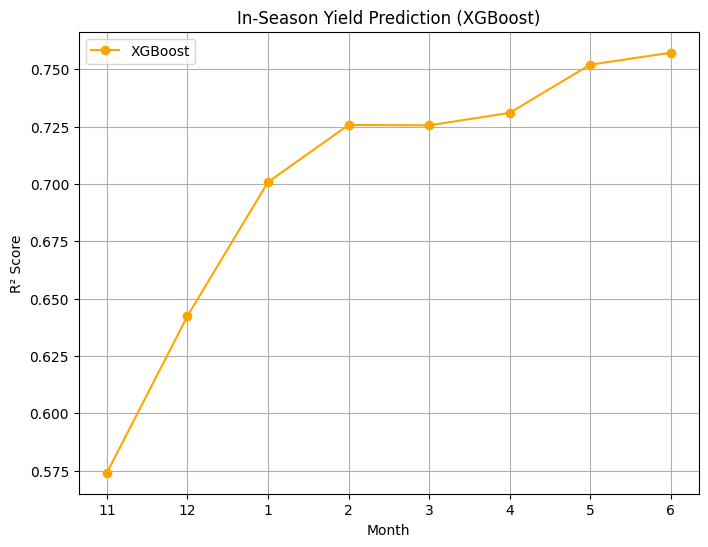

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")

# 特征和标签
feature_cols = [
    'GPP_11','GPP_12','GPP_1','GPP_2','GPP_3','GPP_4','GPP_5','GPP_6',
    'SMCI_11','SMCI_12','SMCI_1','SMCI_2','SMCI_3','SMCI_4','SMCI_5','SMCI_6',
    'TCI_mean_11','TCI_mean_12','TCI_mean_1','TCI_mean_2','TCI_mean_3','TCI_mean_4','TCI_mean_5','TCI_mean_6',
    'VCI_mean_11','VCI_mean_12','VCI_mean_1','VCI_mean_2','VCI_mean_3','VCI_mean_4','VCI_mean_5','VCI_mean_6',
    'Drought_Index'
]
target_col = 'Yield'

# 记录每个月份的表现
r2_scores = []

# 按时间推进建模
month_order = [
    '11', '12', '1', '2', '3', '4', '5', '6'
]

for idx, month in enumerate(month_order):
    selected_features = []
    for feature in feature_cols:
        for m in month_order[:idx+1]:
            if f"_{m}" in feature:
                selected_features.append(feature)
    if 'Drought_Index' not in selected_features and 'Drought_Index' in feature_cols:
        selected_features.append('Drought_Index')

    selected_features = list(set(selected_features))

    X = data[selected_features]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.05)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    r2_scores.append(r2)

# 画图
plt.figure(figsize=(8, 6))
plt.plot(month_order, r2_scores, marker='o', color='orange', label='XGBoost')
plt.xlabel('Month')
plt.ylabel('R² Score')
plt.title('In-Season Yield Prediction (XGBoost)')
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


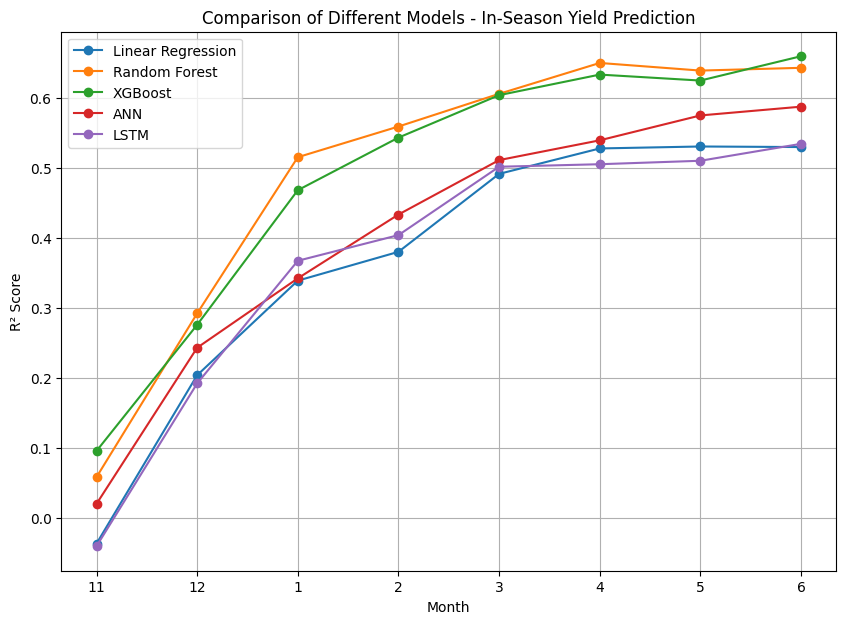

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# 读取数据
data = pd.read_csv('/content/drive/MyDrive/RF/Merged_Seasons_Final.csv')  # 换成你的文件名

# 特征和标签
feature_cols = [
    'GPP_11','GPP_12','GPP_1','GPP_2','GPP_3','GPP_4','GPP_5','GPP_6',
    'SMCI_11','SMCI_12','SMCI_1','SMCI_2','SMCI_3','SMCI_4','SMCI_5','SMCI_6',
    'TCI_mean_11','TCI_mean_12','TCI_mean_1','TCI_mean_2','TCI_mean_3','TCI_mean_4','TCI_mean_5','TCI_mean_6',
    'VCI_mean_11','VCI_mean_12','VCI_mean_1','VCI_mean_2','VCI_mean_3','VCI_mean_4','VCI_mean_5','VCI_mean_6',
]
target_col = 'Drought_Index'

month_order = ['11', '12', '1', '2', '3', '4', '5', '6']

# 记录每个模型的R²曲线
r2_lr = []
r2_rf = []
r2_xgb = []
r2_ann = []
r2_lstm = []

for idx, month in enumerate(month_order):
    selected_features = []
    for feature in feature_cols:
        for m in month_order[:idx+1]:
            if f"_{m}" in feature:
                selected_features.append(feature)
    if 'Drought_Index' not in selected_features and 'Drought_Index' in feature_cols:
        selected_features.append('Drought_Index')

    selected_features = list(set(selected_features))

    X = data[selected_features]
    y = data[target_col]

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ----------------- 1. 线性回归
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    r2_lr.append(r2_score(y_test, y_pred_lr))

    # ----------------- 2. 随机森林
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    r2_rf.append(r2_score(y_test, y_pred_rf))

    # ----------------- 3. XGBoost
    model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.05)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    r2_xgb.append(r2_score(y_test, y_pred_xgb))

    # ----------------- 4. ANN
    model_ann = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_ann.compile(optimizer=Adam(0.001), loss='mse')
    model_ann.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred_ann = model_ann.predict(X_test).flatten()
    r2_ann.append(r2_score(y_test, y_pred_ann))

    # ----------------- 5. LSTM
    # LSTM要求输入3D (samples, timesteps, features)
    X_train_lstm = np.expand_dims(X_train, axis=1)
    X_test_lstm = np.expand_dims(X_test, axis=1)

    model_lstm = Sequential([
        LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer=Adam(0.001), loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
    r2_lstm.append(r2_score(y_test, y_pred_lstm))

# ----------------- 绘图
plt.figure(figsize=(10, 7))
plt.plot(month_order, r2_lr, marker='o', label='Linear Regression')
plt.plot(month_order, r2_rf, marker='o', label='Random Forest')
plt.plot(month_order, r2_xgb, marker='o', label='XGBoost')
plt.plot(month_order, r2_ann, marker='o', label='ANN')
plt.plot(month_order, r2_lstm, marker='o', label='LSTM')

plt.xlabel('Month')
plt.ylabel('R² Score')
plt.title('Comparison of Different Models - In-Season Yield Prediction')
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


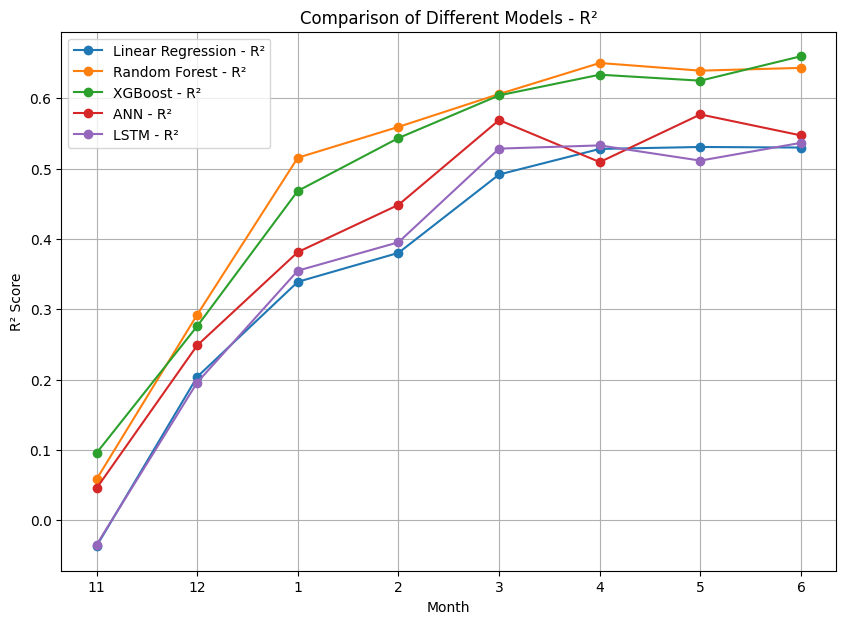

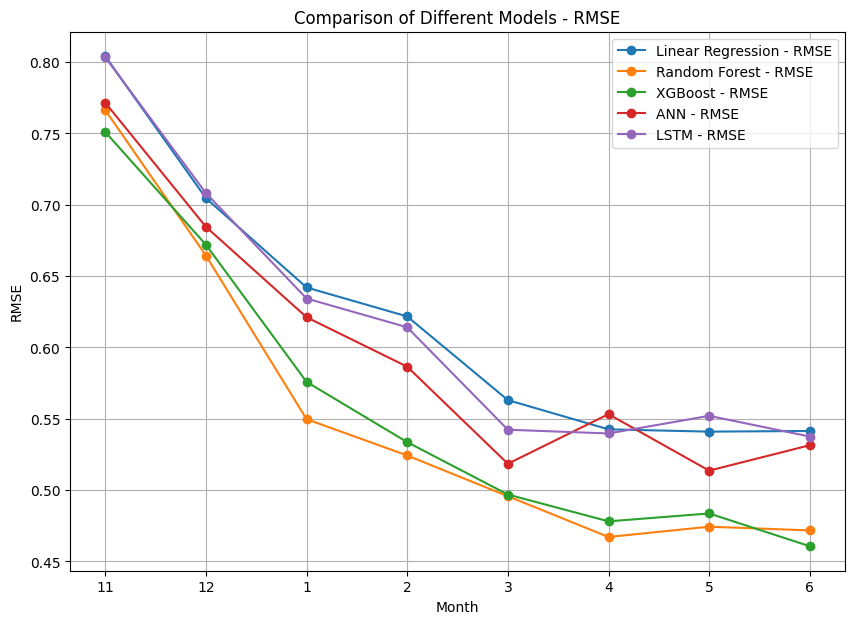

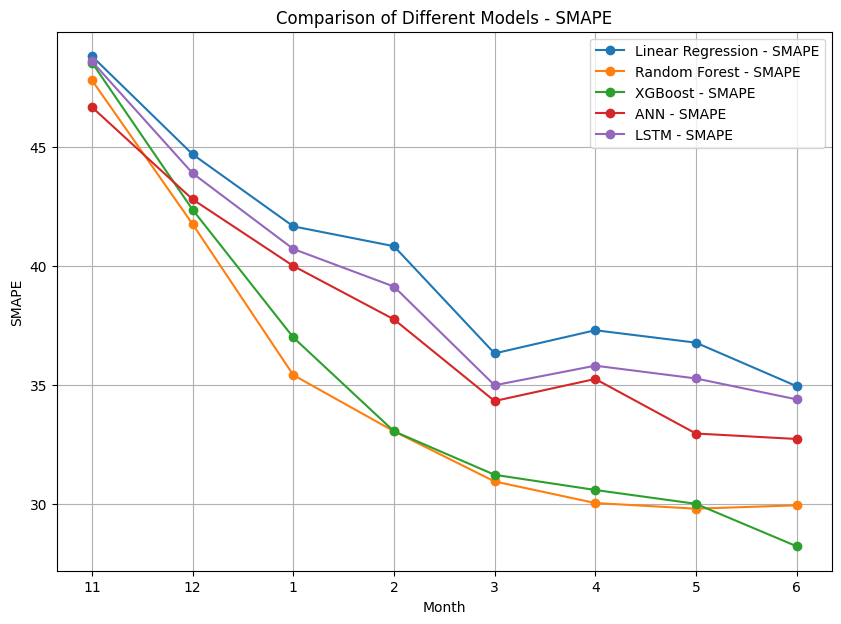

In [ ]:
from sklearn.metrics import mean_squared_error

# 函数：计算SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)) * 100)

# 记录每个模型的R², RMSE 和 SMAPE 曲线
r2_lr, rmse_lr, smape_lr = [], [], []
r2_rf, rmse_rf, smape_rf = [], [], []
r2_xgb, rmse_xgb, smape_xgb = [], [], []
r2_ann, rmse_ann, smape_ann = [], [], []
r2_lstm, rmse_lstm, smape_lstm = [], [], []

for idx, month in enumerate(month_order):
    selected_features = []
    for feature in feature_cols:
        for m in month_order[:idx+1]:
            if f"_{m}" in feature:
                selected_features.append(feature)
    if 'Drought_Index' not in selected_features and 'Drought_Index' in feature_cols:
        selected_features.append('Drought_Index')

    selected_features = list(set(selected_features))

    X = data[selected_features]
    y = data[target_col]

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ----------------- 1. 线性回归
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    r2_lr.append(r2_score(y_test, y_pred_lr))
    rmse_lr.append(np.sqrt(mean_squared_error(y_test, y_pred_lr)))
    smape_lr.append(smape(y_test, y_pred_lr))

    # ----------------- 2. 随机森林
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    r2_rf.append(r2_score(y_test, y_pred_rf))
    rmse_rf.append(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
    smape_rf.append(smape(y_test, y_pred_rf))

    # ----------------- 3. XGBoost
    model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.05)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    r2_xgb.append(r2_score(y_test, y_pred_xgb))
    rmse_xgb.append(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
    smape_xgb.append(smape(y_test, y_pred_xgb))

    # ----------------- 4. ANN
    model_ann = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_ann.compile(optimizer=Adam(0.001), loss='mse')
    model_ann.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred_ann = model_ann.predict(X_test).flatten()
    r2_ann.append(r2_score(y_test, y_pred_ann))
    rmse_ann.append(np.sqrt(mean_squared_error(y_test, y_pred_ann)))
    smape_ann.append(smape(y_test, y_pred_ann))

    # ----------------- 5. LSTM
    # LSTM要求输入3D (samples, timesteps, features)
    X_train_lstm = np.expand_dims(X_train, axis=1)
    X_test_lstm = np.expand_dims(X_test, axis=1)

    model_lstm = Sequential([
        LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer=Adam(0.001), loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
    r2_lstm.append(r2_score(y_test, y_pred_lstm))
    rmse_lstm.append(np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
    smape_lstm.append(smape(y_test, y_pred_lstm))

# ----------------- 绘图
plt.figure(figsize=(10, 7))
plt.plot(month_order, r2_lr, marker='o', label='Linear Regression - R²')
plt.plot(month_order, r2_rf, marker='o', label='Random Forest - R²')
plt.plot(month_order, r2_xgb, marker='o', label='XGBoost - R²')
plt.plot(month_order, r2_ann, marker='o', label='ANN - R²')
plt.plot(month_order, r2_lstm, marker='o', label='LSTM - R²')

plt.xlabel('Month')
plt.ylabel('R² Score')
plt.title('Comparison of Different Models - R²')
plt.grid(True)
plt.legend()
plt.show()

# RMSE图
plt.figure(figsize=(10, 7))
plt.plot(month_order, rmse_lr, marker='o', label='Linear Regression - RMSE')
plt.plot(month_order, rmse_rf, marker='o', label='Random Forest - RMSE')
plt.plot(month_order, rmse_xgb, marker='o', label='XGBoost - RMSE')
plt.plot(month_order, rmse_ann, marker='o', label='ANN - RMSE')
plt.plot(month_order, rmse_lstm, marker='o', label='LSTM - RMSE')

plt.xlabel('Month')
plt.ylabel('RMSE')
plt.title('Comparison of Different Models - RMSE')
plt.grid(True)
plt.legend()
plt.show()

# SMAPE图
plt.figure(figsize=(10, 7))
plt.plot(month_order, smape_lr, marker='o', label='Linear Regression - SMAPE')
plt.plot(month_order, smape_rf, marker='o', label='Random Forest - SMAPE')
plt.plot(month_order, smape_xgb, marker='o', label='XGBoost - SMAPE')
plt.plot(month_order, smape_ann, marker='o', label='ANN - SMAPE')
plt.plot(month_order, smape_lstm, marker='o', label='LSTM - SMAPE')

plt.xlabel('Month')
plt.ylabel('SMAPE')
plt.title('Comparison of Different Models - SMAPE')
plt.grid(True)
plt.legend()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. 读取数据
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
df = df.dropna()

# 2. 定义月份和变量名
months = ['11', '12', '1', '2', '3', '4', '5', '6']
variables = ['GPP', 'SMCI', 'TCI_mean', 'VCI_mean']

# 3. 创建特征矩阵
features_all = []
for month in months:
    features_all.extend([f"{var}_{month}" for var in variables])

X = df[features_all].values.reshape(-1, len(months), len(variables))  # (样本数, 8个月, 4个变量)
y = df['Yield'].values  # 原始 Yield anomaly

# 4. 标准化 y（Min-Max Normalization到 [0,1]）
y_min = y.min()
y_max = y.max()
y_normalized = (y - y_min) / (y_max - y_min)

# 5. 保存每个月的回归权重
month_coefficients = {}

# 6. 对每个月分别做多元线性回归
for idx, month in enumerate(months):
    X_month = X[:, idx, :]  # 当前月的数据 (样本数, 4个特征)

    model = LinearRegression()
    model.fit(X_month, y_normalized)

    coeffs = model.coef_
    intercept = model.intercept_

    month_coefficients[month] = {
        'intercept': intercept,
        'GPP_coef': coeffs[0],
        'SMCI_coef': coeffs[1],
        'TCI_mean_coef': coeffs[2],
        'VCI_mean_coef': coeffs[3]
    }

# 7. 整理成表格
coef_table = pd.DataFrame(month_coefficients).T
print(coef_table)

# 8. 保存到CSV
coef_table.to_csv("/content/drive/MyDrive/RF/monthly_regression_coefficients_normalized_y.csv")



    intercept  GPP_coef  SMCI_coef  TCI_mean_coef  VCI_mean_coef
11   0.425762  0.129671  -0.004561      -0.055227      -0.098394
12   0.131286  0.400945   0.085766       0.389624      -0.308576
1    0.070079  0.176943   0.068263       0.494773      -0.054217
2    0.120128  0.341753  -0.108161       0.488133      -0.035368
3    0.127343  0.553169  -0.114969       0.273397      -0.042177
4    0.316741  0.263681  -0.417397       0.112948       0.304759
5    0.267572 -0.002036  -0.348020       0.246947       0.366885
6    0.210822 -0.105343  -0.120724       0.241803       0.372108


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. 读取和准备数据
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
df = df.dropna()

months = ['11', '12', '1', '2', '3', '4', '5', '6']
variables = ['GPP', 'SMCI', 'TCI_mean', 'VCI_mean']

# 2. 标准化 y
y = df['Yield'].values
y_min = y.min()
y_max = y.max()
y_normalized = (y - y_min) / (y_max - y_min)

# 3. 用 statsmodels 做每月的多元线性回归，提取 coef 和 p-value
results_list = []

for month in months:
    X_month = df[[f"{var}_{month}" for var in variables]].copy()
    X_month.columns = variables  # 重命名为统一列名
    X_month = sm.add_constant(X_month)  # 添加截距项

    model = sm.OLS(y_normalized, X_month)
    results = model.fit()

    for var in ['const'] + variables:
        results_list.append({
            'Month': month,
            'Feature': 'intercept' if var == 'const' else var,
            'Coef': results.params[var],
            'P_value': results.pvalues[var]
        })

# 4. 整理结果成表格
results_df = pd.DataFrame(results_list)
print(results_df)

# 5. 保存结果
results_df.to_csv("/content/drive/MyDrive/RF/monthly_coef_pvalue_table.csv", index=False)


   Month    Feature      Coef       P_value
0     11  intercept  0.425762  1.419296e-26
1     11        GPP  0.129671  1.856907e-01
2     11       SMCI -0.004561  9.598246e-01
3     11   TCI_mean -0.055227  6.179244e-01
4     11   VCI_mean -0.098394  2.948091e-01
5     12  intercept  0.131286  1.329546e-03
6     12        GPP  0.400945  1.481783e-06
7     12       SMCI  0.085766  2.293687e-01
8     12   TCI_mean  0.389624  5.624777e-08
9     12   VCI_mean -0.308576  9.535629e-05
10     1  intercept  0.070079  5.658012e-02
11     1        GPP  0.176943  2.835104e-02
12     1       SMCI  0.068263  3.070282e-01
13     1   TCI_mean  0.494773  7.306425e-12
14     1   VCI_mean -0.054217  4.996022e-01
15     2  intercept  0.120128  3.022241e-04
16     2        GPP  0.341753  2.875756e-06
17     2       SMCI -0.108161  5.952591e-02
18     2   TCI_mean  0.488133  1.060066e-17
19     2   VCI_mean -0.035368  6.178819e-01
20     3  intercept  0.127343  2.316637e-05
21     3        GPP  0.553169  3

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. 读取和准备数据
df = pd.read_csv("/content/drive/MyDrive/RF/Merged_Seasons_Final.csv")
df = df.dropna()

# 定义区域
zone_dict = {
    'zone1': ['Settat', 'Khouribga', 'El Jadida'],
    'zone2': ['Kénitra', 'Béni Mellal', 'Azilal', 'Ifrane', 'Boulemane'],
    'zone3': ['Safi', 'Marrakech', 'El Kelaâ des Sraghna', 'Al Haouz', 'Chichaoua']
}

# 添加 zone4，其余未在 zone1~3 中的
all_defined = sum(zone_dict.values(), [])  # 展平成一个列表
df['Zone'] = 'zone4'
for zone_name, provinces in zone_dict.items():
    df.loc[df['Province'].isin(provinces), 'Zone'] = zone_name

months = ['11', '12', '1', '2', '3', '4', '5', '6']
variables = ['GPP', 'SMCI', 'TCI_mean', 'VCI_mean']

# 2. 标准化 y（统一标准化）
y = df['Yield'].values
y_min = y.min()
y_max = y.max()
df['Yield_normalized'] = (y - y_min) / (y_max - y_min)

# 3. 每个 zone 分别回归分析
final_results = []

for zone in df['Zone'].unique():
    df_zone = df[df['Zone'] == zone]
    y_zone = df_zone['Yield_normalized'].values

    for month in months:
        try:
            X_month = df_zone[[f"{var}_{month}" for var in variables]].copy()
            X_month.columns = variables  # 重命名列
            X_month = sm.add_constant(X_month)  # 添加常数项

            model = sm.OLS(y_zone, X_month)
            results = model.fit()

            for var in ['const'] + variables:
                final_results.append({
                    'Zone': zone,
                    'Month': month,
                    'Feature': 'intercept' if var == 'const' else var,
                    'Coef': results.params[var],
                    'P_value': results.pvalues[var]
                })
        except Exception as e:
            print(f"Skipping {zone} {month} due to error: {e}")

# 4. 保存结果为 DataFrame
results_df = pd.DataFrame(final_results)
print(results_df)

# 5. 保存结果
results_df.to_csv("/content/drive/MyDrive/RF/monthly_coef_pvalue_by_zone.csv", index=False)


      Zone Month    Feature      Coef   P_value
0    zone3    11  intercept  0.218645  0.022305
1    zone3    11        GPP  0.248605  0.472991
2    zone3    11       SMCI  0.314922  0.145015
3    zone3    11   TCI_mean  0.010325  0.971335
4    zone3    11   VCI_mean -0.254921  0.440796
..     ...   ...        ...       ...       ...
155  zone1     6  intercept  0.119210  0.173286
156  zone1     6        GPP -0.255733  0.084868
157  zone1     6       SMCI -0.100350  0.799534
158  zone1     6   TCI_mean  0.587141  0.008962
159  zone1     6   VCI_mean  0.336356  0.021876

[160 rows x 5 columns]


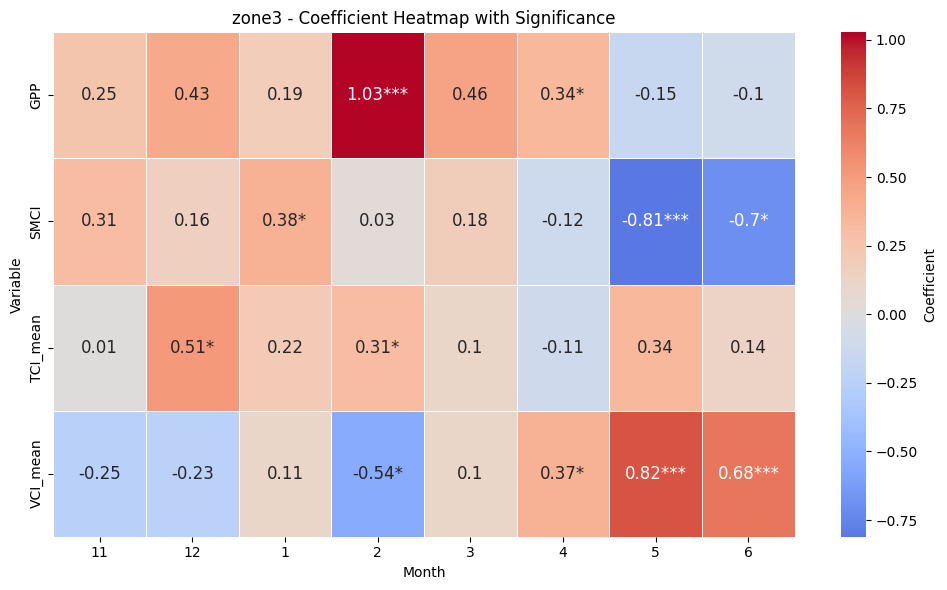

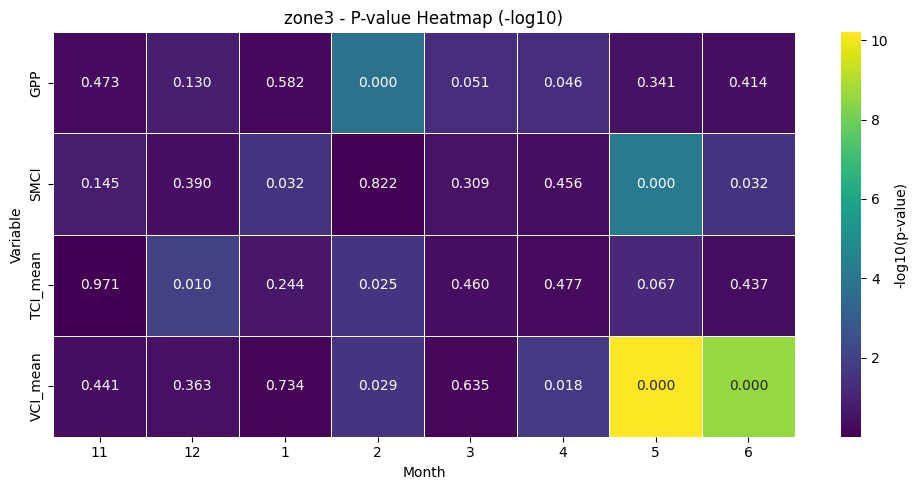

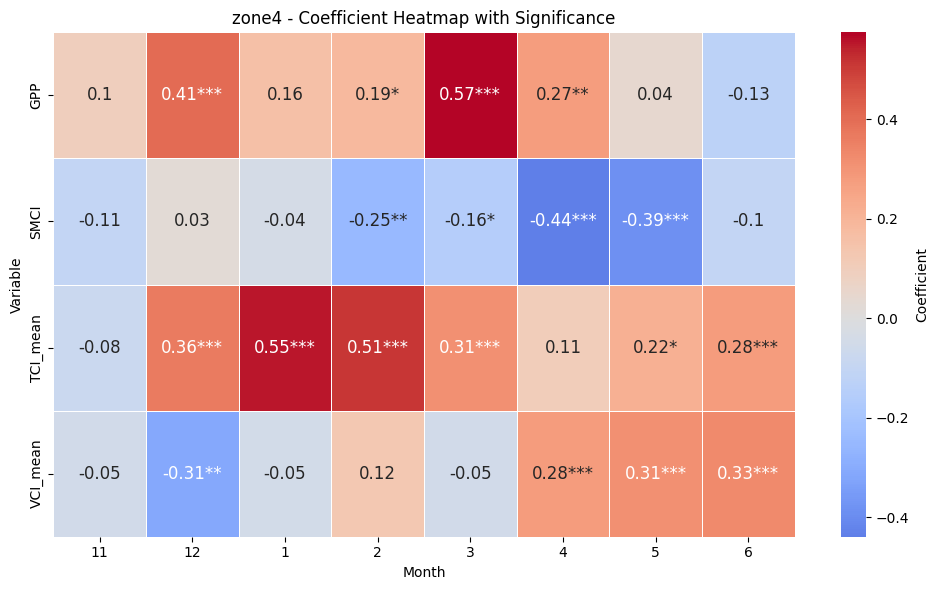

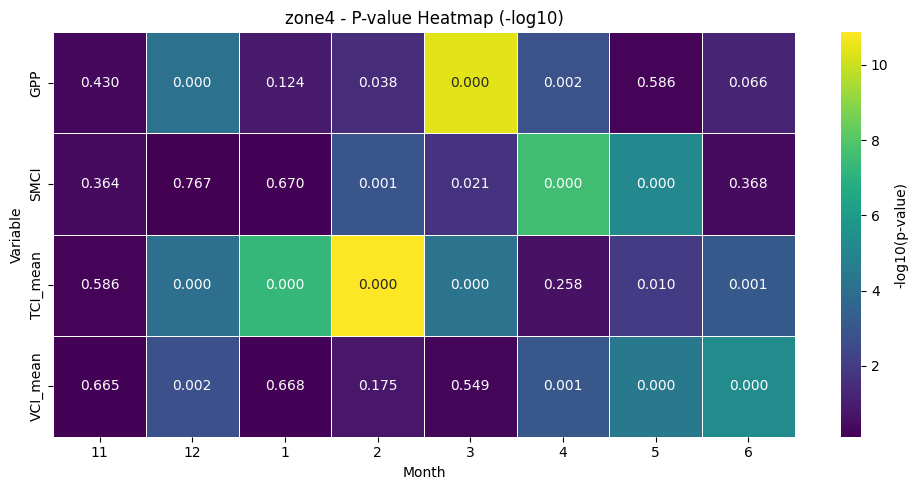

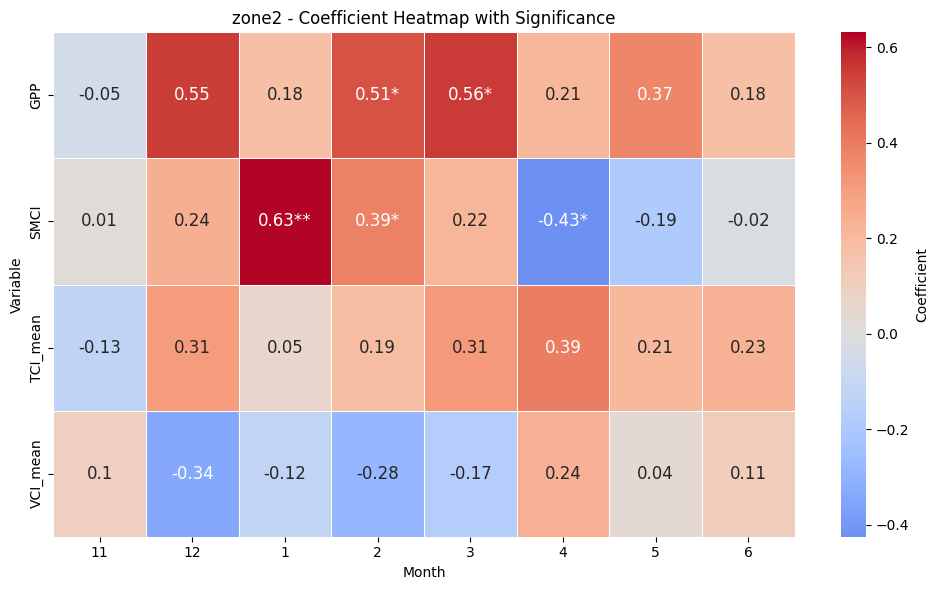

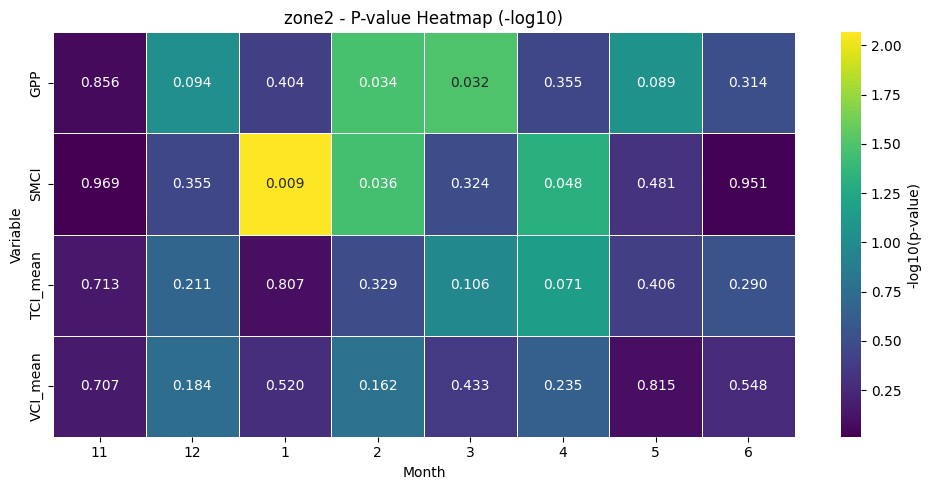

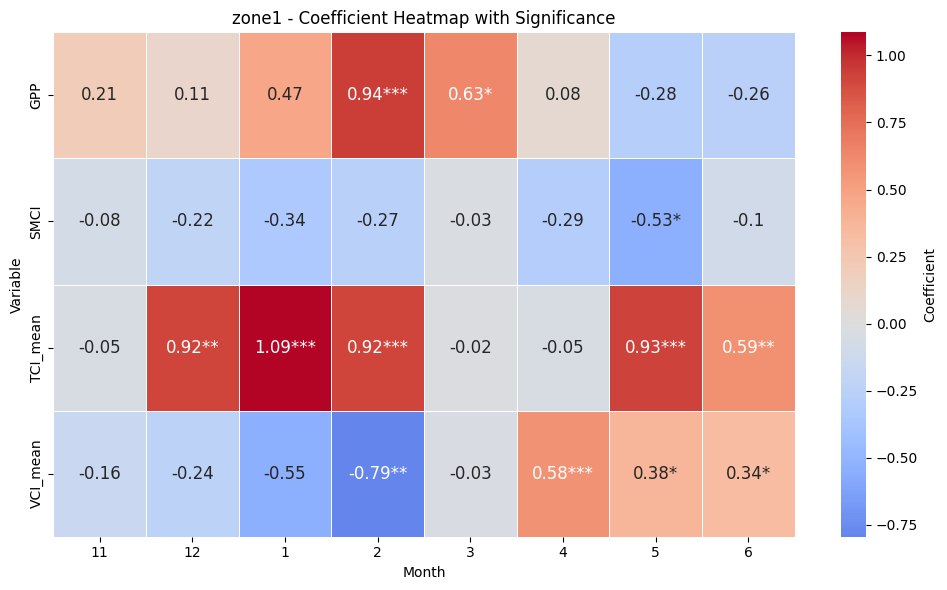

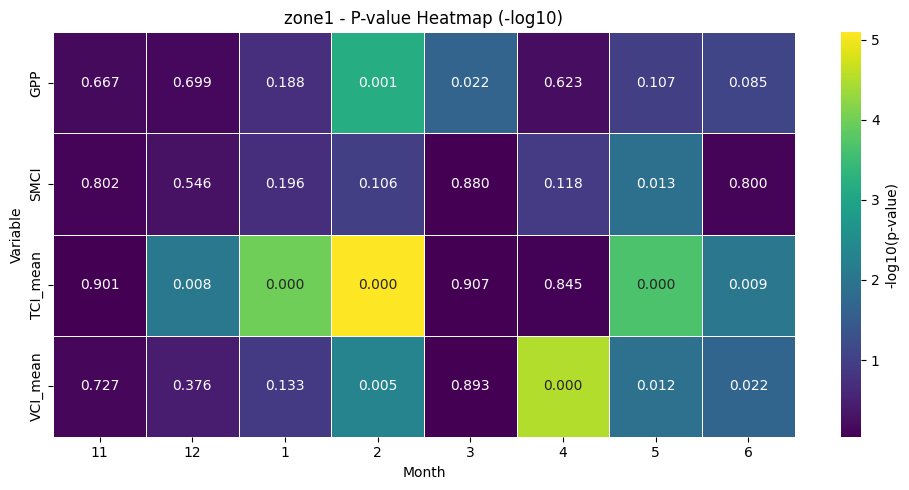

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 月份顺序（字符串形式）
month_order = ['11', '12', '1', '2', '3', '4', '5', '6']
variables = ['GPP', 'SMCI', 'TCI_mean', 'VCI_mean']

# 显著性标注函数
def add_significance(pvals):
    signs = np.full(pvals.shape, '', dtype=object)
    signs[pvals < 0.001] = '***'
    signs[(pvals >= 0.001) & (pvals < 0.01)] = '**'
    signs[(pvals >= 0.01) & (pvals < 0.05)] = '*'
    return signs

# 遍历每个 Zone
for zone in results_df['Zone'].unique():
    sub_df = results_df[(results_df['Zone'] == zone) & (results_df['Feature'] != 'intercept')]

    # 构造矩阵
    coeff_matrix = sub_df.pivot(index='Feature', columns='Month', values='Coef').reindex(index=variables, columns=month_order)
    pvalue_matrix = sub_df.pivot(index='Feature', columns='Month', values='P_value').reindex(index=variables, columns=month_order)

    # 热力图 1：系数 + 显著性标注
    annot_text = np.char.add(np.round(coeff_matrix.values, 2).astype(str),
                             add_significance(pvalue_matrix.values))

    plt.figure(figsize=(10, 6))
    sns.heatmap(coeff_matrix, annot=annot_text, fmt='', cmap='coolwarm', center=0,
                linewidths=0.5, cbar_kws={'label': 'Coefficient'}, annot_kws={"size": 12})
    plt.title(f'{zone} - Coefficient Heatmap with Significance')
    plt.xlabel('Month')
    plt.ylabel('Variable')
    plt.xticks(ticks=np.arange(len(month_order)) + 0.5, labels=month_order)
    plt.tight_layout()
    plt.show()

    # 热力图 2：p值（log变换）
    plt.figure(figsize=(10, 5))
    sns.heatmap(-np.log10(pvalue_matrix), annot=np.round(pvalue_matrix.values, 3),
                cmap='viridis', fmt=".3f", linewidths=0.5,
                cbar_kws={'label': '-log10(p-value)'})
    plt.title(f'{zone} - P-value Heatmap (-log10)')
    plt.xlabel('Month')
    plt.ylabel('Variable')
    plt.xticks(ticks=np.arange(len(month_order)) + 0.5, labels=month_order)
    plt.tight_layout()
    plt.show()



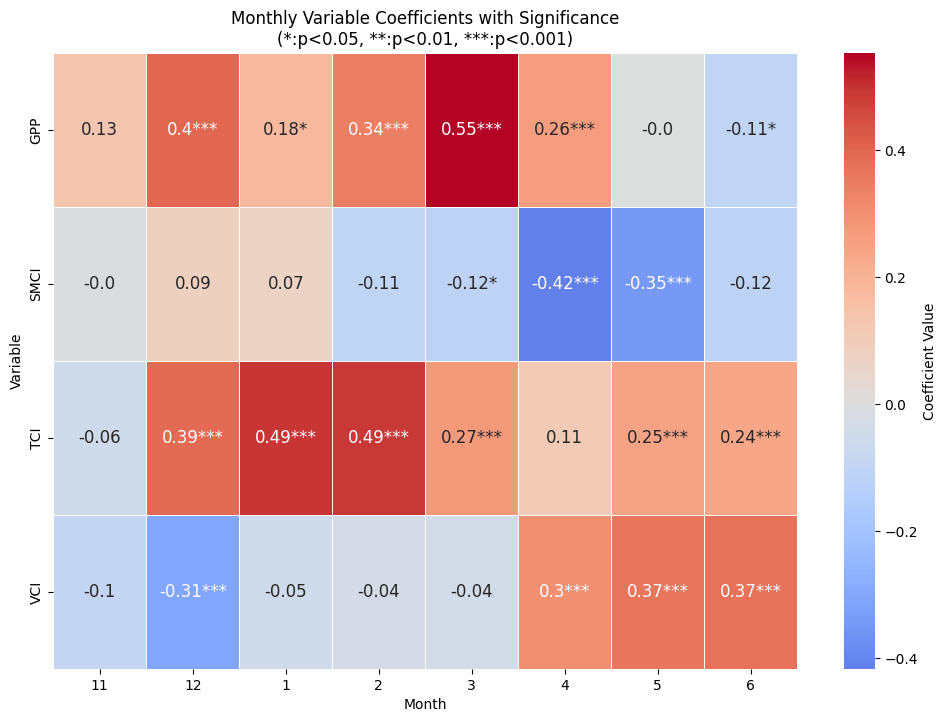

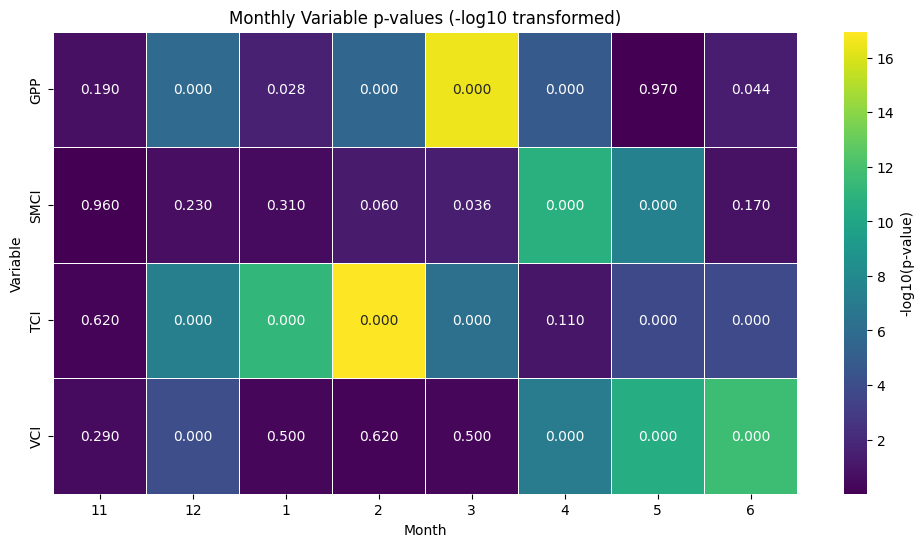

In [7]:
# 指定月份顺序
month_order = [11, 12, 1, 2, 3, 4, 5, 6]

# 定义显著性标注函数
def add_significance(pvals):
    signs = np.full(pvals.shape, '', dtype=object)
    signs[pvals < 0.001] = '***'
    signs[(pvals >= 0.001) & (pvals < 0.01)] = '**'
    signs[(pvals >= 0.01) & (pvals < 0.05)] = '*'
    return signs

# 生成标注文本（值 + 显著性）
annot_text = np.char.add(np.round(coeff_matrix.T.loc[:, month_order].values, 2).astype(str),
                         add_significance(pvalue_matrix.T.loc[:, month_order].values))

# 绘制系数热力图（按生长季排序）
plt.figure(figsize=(12, 8))
sns.heatmap(coeff_matrix.T.loc[:, month_order],
            annot=annot_text,
            fmt="",
            cmap='coolwarm',
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Coefficient Value'},
            annot_kws={"size":12})
plt.title('Monthly Variable Coefficients with Significance\n(*:p<0.05, **:p<0.01, ***:p<0.001)')
plt.xlabel('Month')
plt.ylabel('Variable')
plt.xticks(ticks=np.arange(8) + 0.5, labels=month_order)  # 保证x轴标签正确
plt.show()

# 绘制p值热力图（log转换，按生长季排序）
plt.figure(figsize=(12, 6))
sns.heatmap(-np.log10(pvalue_matrix.T.loc[:, month_order]),
            annot=np.round(pvalue_matrix.T.loc[:, month_order].values, 3),
            cmap='viridis',
            fmt=".3f",
            linewidths=0.5,
            cbar_kws={'label': '-log10(p-value)'})
plt.title('Monthly Variable p-values (-log10 transformed)')
plt.xlabel('Month')
plt.ylabel('Variable')
plt.xticks(ticks=np.arange(8) + 0.5, labels=month_order)
plt.show()




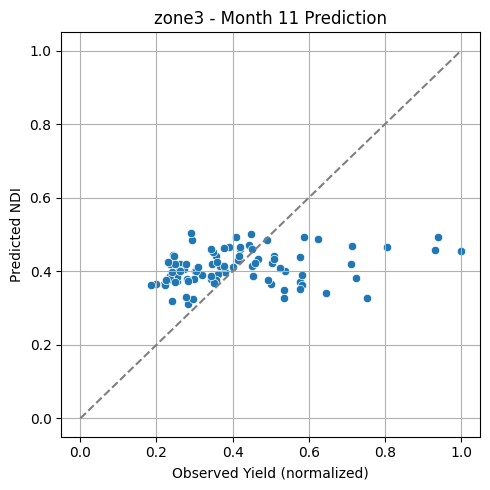

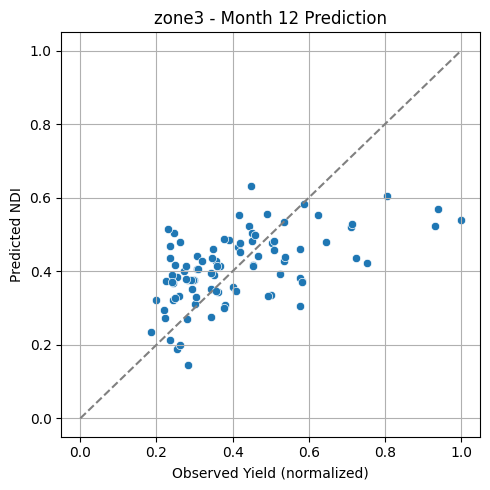

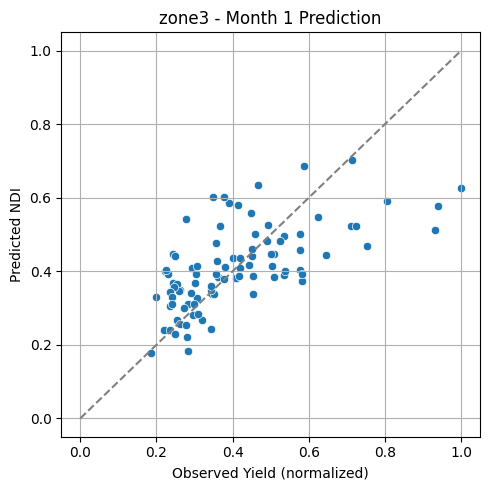

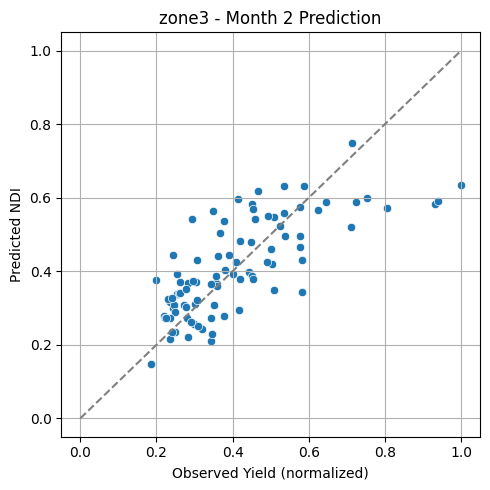

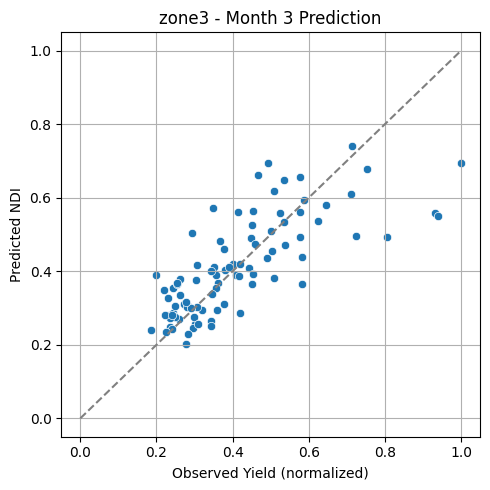

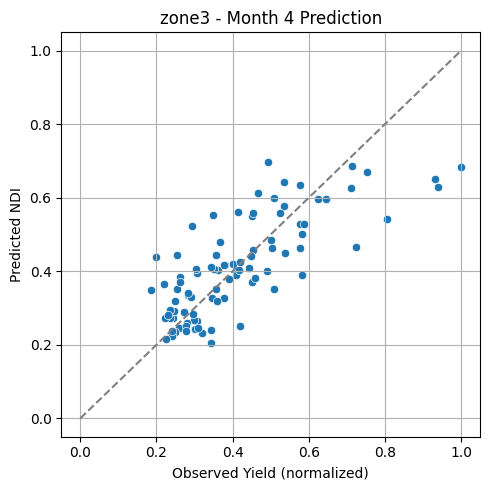

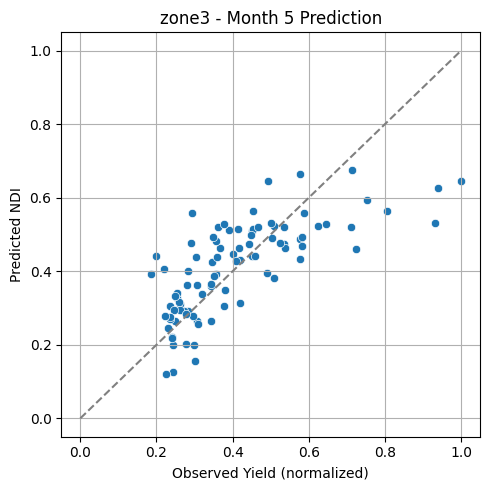

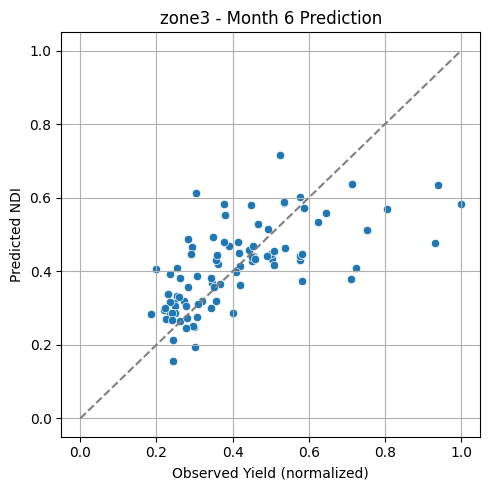

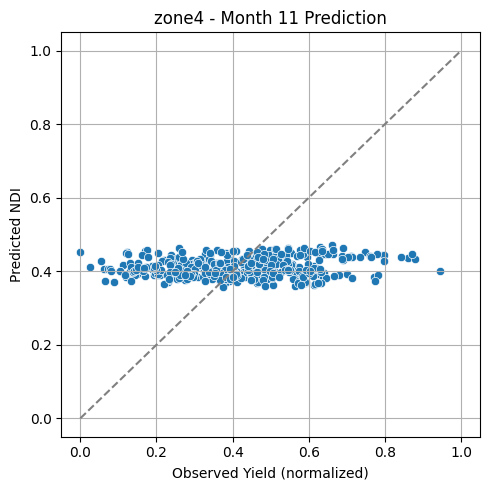

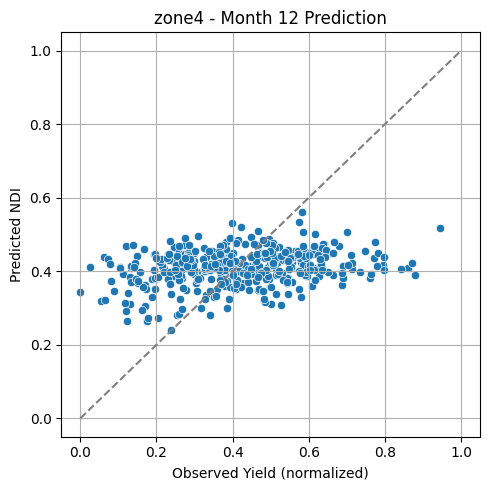

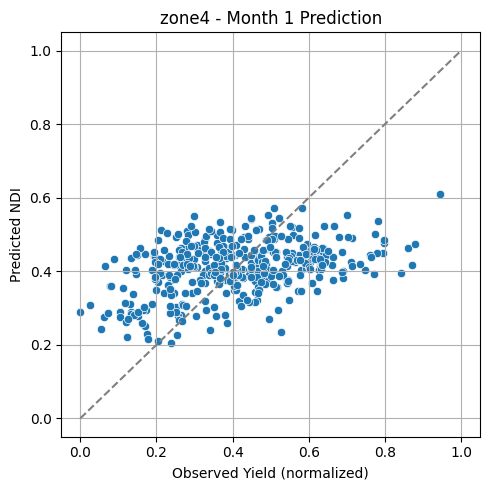

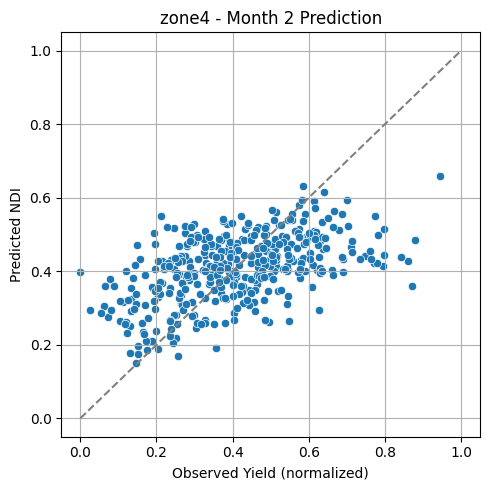

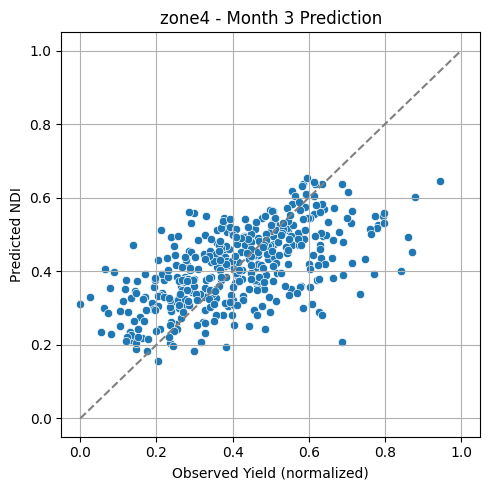

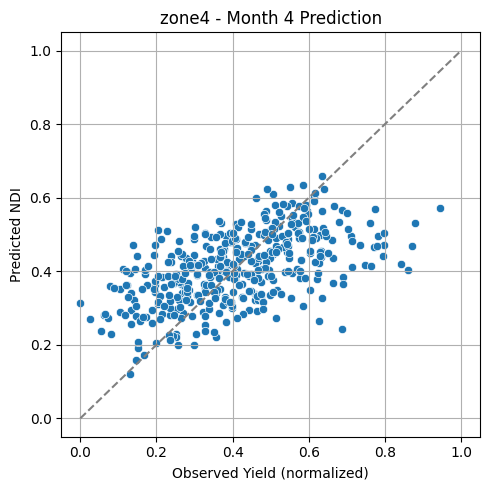

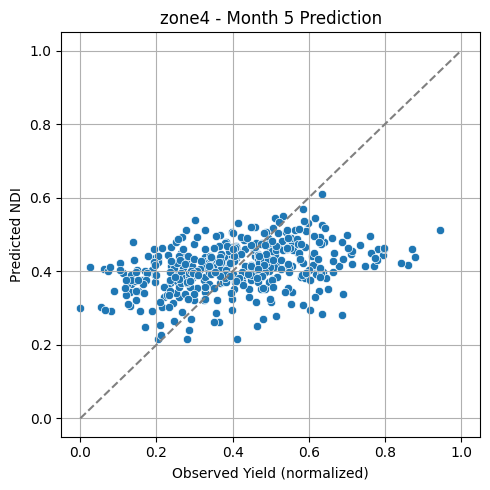

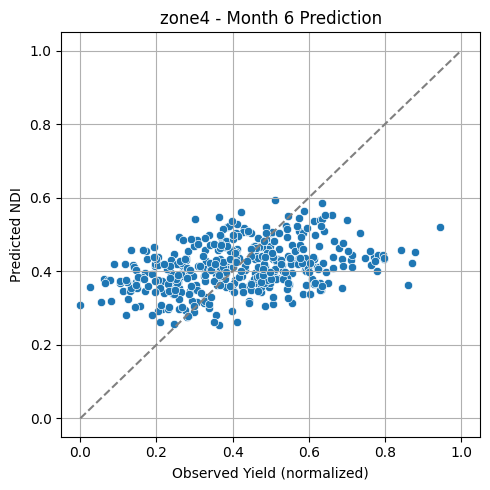

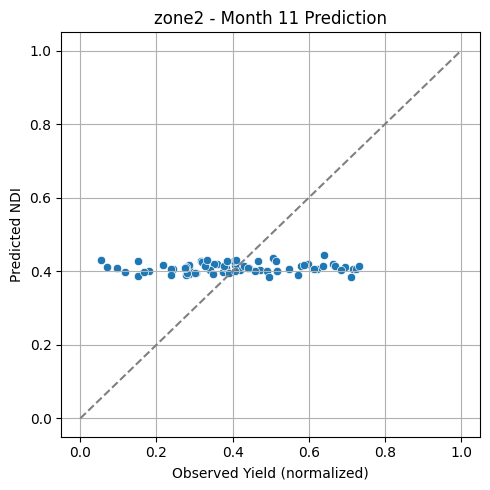

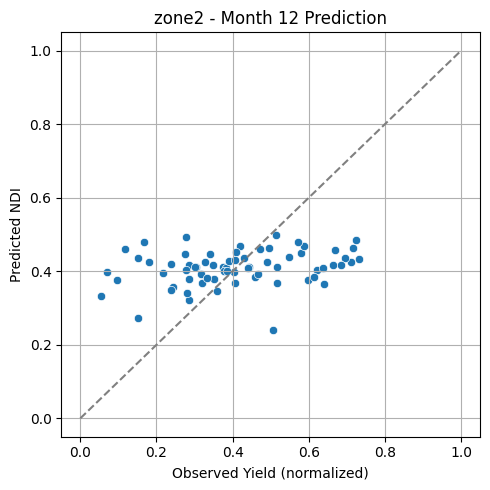

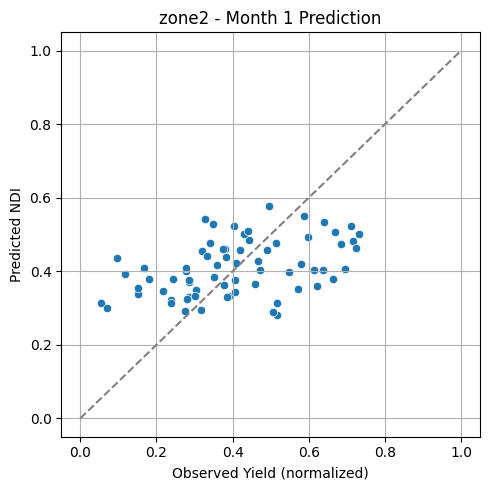

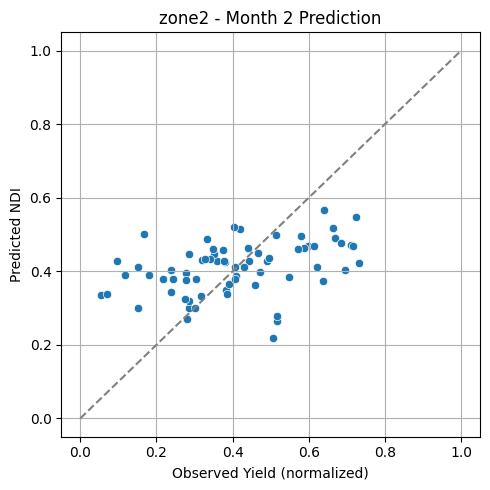

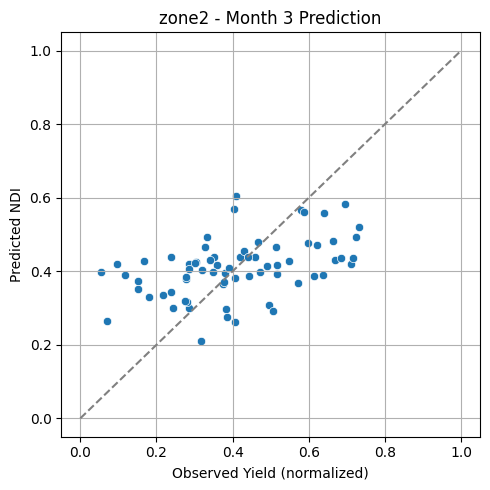

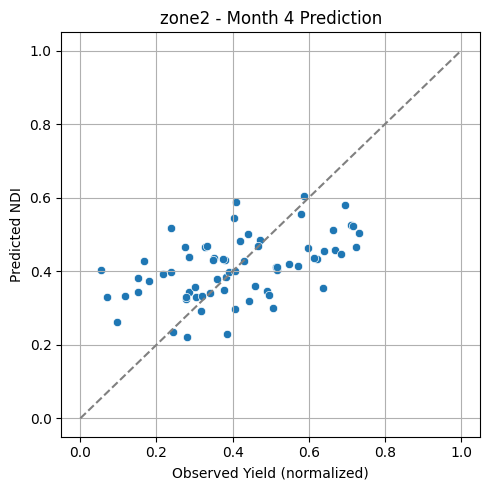

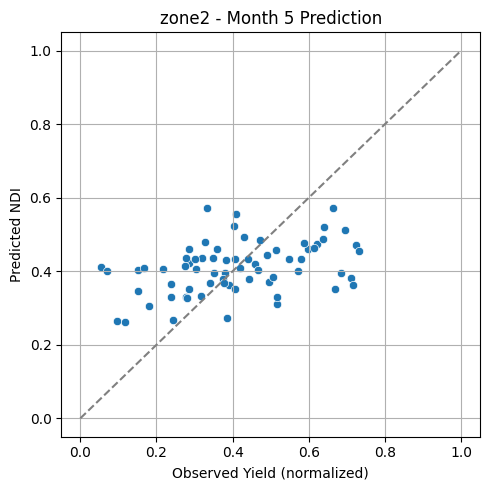

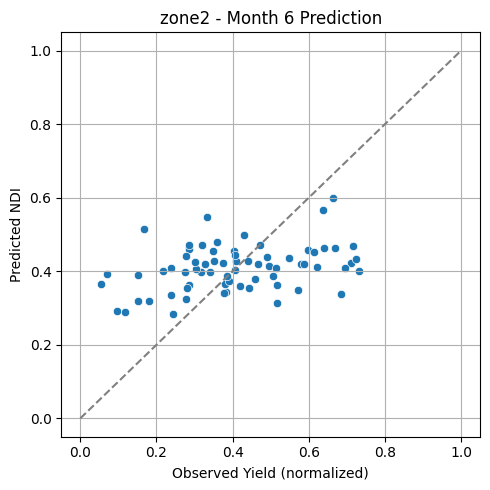

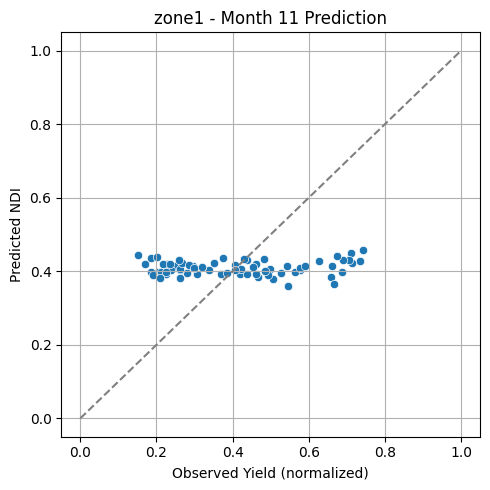

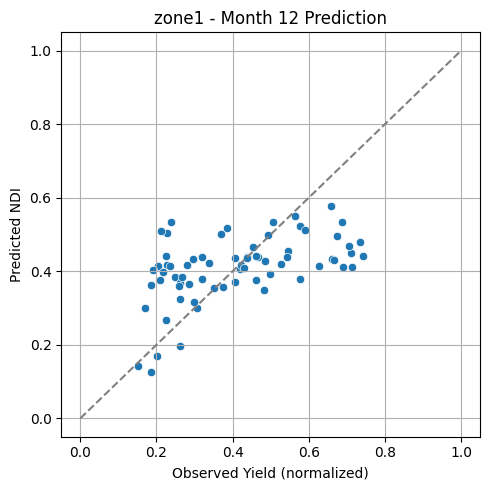

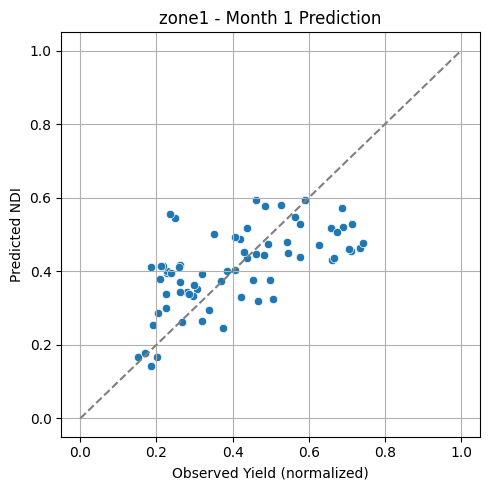

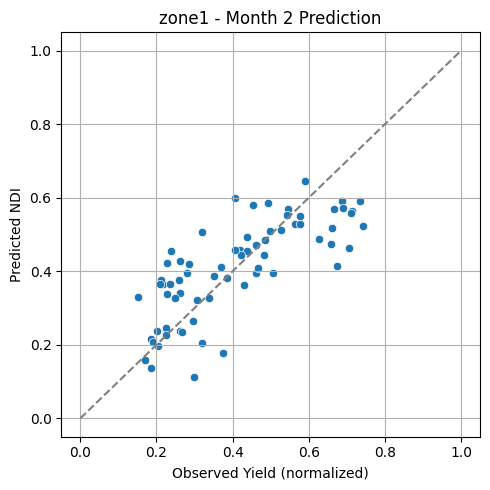

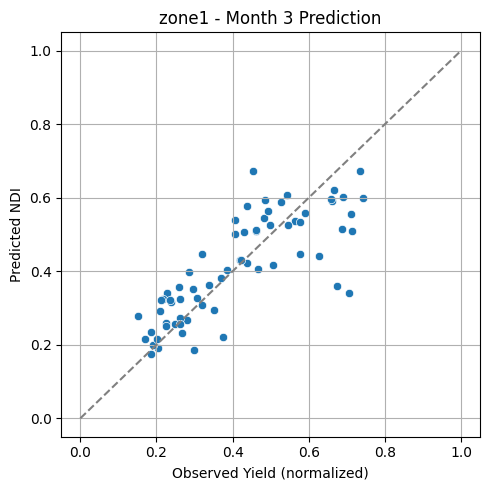

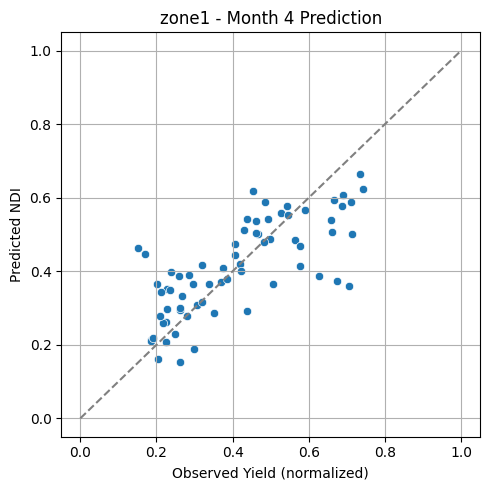

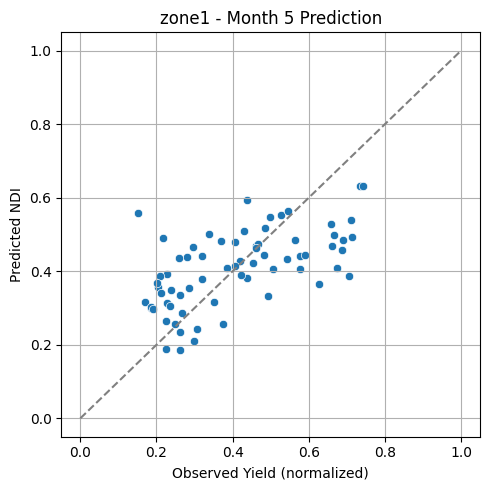

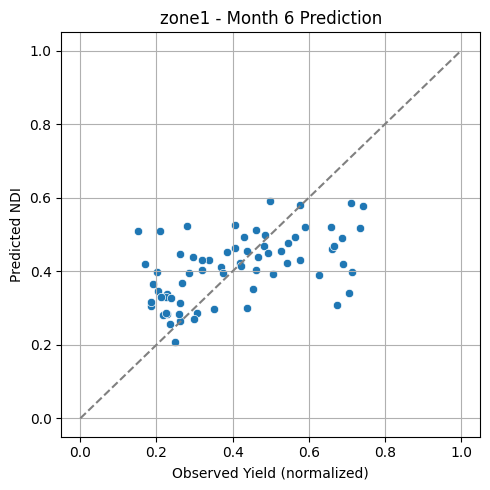

     Zone Month        R2      RMSE
4   zone1     3  0.636039  0.104286
21  zone3     4  0.592248  0.110381
20  zone3     3  0.573158  0.112936
3   zone1     2  0.568691  0.113525
19  zone3     2  0.550187  0.115935
5   zone1     4  0.544221  0.116701
22  zone3     5  0.527079  0.118876
23  zone3     6  0.427221  0.130825
16  zone3     1  0.413471  0.132386
0   zone1     1  0.375921  0.136558
显著变量出现次数：
 Feature
TCI_mean    13
VCI_mean    12
SMCI        11
GPP         10
dtype: int64


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

final_results = []
all_predictions = []

for zone in df['Zone'].unique():
    df_zone = df[df['Zone'] == zone]
    y_zone = df_zone['Yield_normalized'].values

    for month in months:
        try:
            X_month = df_zone[[f"{var}_{month}" for var in variables]].copy()
            X_month.columns = variables
            X_month = sm.add_constant(X_month)
            model = sm.OLS(y_zone, X_month)
            results = model.fit()
            y_pred = results.predict(X_month)

            r2 = r2_score(y_zone, y_pred)
            rmse = np.sqrt(mean_squared_error(y_zone, y_pred))

            for var in ['const'] + variables:
                final_results.append({
                    'Zone': zone,
                    'Month': month,
                    'Feature': 'intercept' if var == 'const' else var,
                    'Coef': results.params[var],
                    'P_value': results.pvalues[var],
                    'R2': r2,
                    'RMSE': rmse
                })

            # 保存每个样本点的预测结果
            df_preds = df_zone[['Province']].copy()
            df_preds['Zone'] = zone
            df_preds['Month'] = month
            df_preds['Yield_true'] = y_zone
            df_preds['NDI_pred'] = y_pred
            all_predictions.append(df_preds)

        except Exception as e:
            print(f"Skipping {zone} {month} due to error: {e}")
results_df = pd.DataFrame(final_results)
results_df.to_csv("/content/drive/MyDrive/RF/monthly_coef_pvalue_r2_rmse.csv", index=False)

preds_df = pd.concat(all_predictions, ignore_index=True)
preds_df.to_csv("/content/drive/MyDrive/RF/monthly_predictions.csv", index=False)
import seaborn as sns
import matplotlib.pyplot as plt

# 示例：绘制每个 Zone 每月的预测效果
for zone in preds_df['Zone'].unique():
    for month in month_order:
        sub = preds_df[(preds_df['Zone'] == zone) & (preds_df['Month'] == month)]

        if sub.empty:
            continue

        plt.figure(figsize=(5, 5))
        sns.scatterplot(x='Yield_true', y='NDI_pred', data=sub)
        plt.plot([0, 1], [0, 1], '--', color='gray')  # 对角线
        plt.xlabel('Observed Yield (normalized)')
        plt.ylabel('Predicted NDI')
        plt.title(f'{zone} - Month {month} Prediction')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# 平均每个模型的 R² / RMSE
summary_stats = results_df[results_df['Feature'] == 'intercept'].groupby(['Zone', 'Month'])[['R2', 'RMSE']].mean().reset_index()

# 找出 R² 最大（或 RMSE 最小）的月份/区
best_models = summary_stats.sort_values(by='R2', ascending=False).head(10)
print(best_models)
# 统计各变量在多少模型中显著
sig_vars = results_df[(results_df['P_value'] < 0.05) & (results_df['Feature'] != 'intercept')]
important_counts = sig_vars.groupby('Feature').size().sort_values(ascending=False)
print("显著变量出现次数：\n", important_counts)
